## Face Detection

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os 
import time
import uuid
import cv2
from matplotlib import pyplot as plt 

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range (number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(1)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [9]:
!labelme

## Review Dataset and Build Image Loading Function

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid Out Of Memory errors by setting GPU Memory Consumption Growth
#tf.config.list_physical_devices('GPU') ##check if you have a GPu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

#### Load Image into TF Data Pipeline

In [5]:
##full data path
images = tf.data.Dataset.list_files('data\\images\\*.jpg')##can add shuffle=False to avoid shuffling

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [14]:
images.as_numpy_iterator().next()

b'data\\images\\c606a16d-bd0d-11ed-94c2-c42360996e83.jpg'

In [15]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[155, 160, 163],
        [159, 164, 167],
        [155, 160, 163],
        ...,
        [231, 246, 241],
        [225, 242, 236],
        [221, 238, 232]],

       [[160, 165, 168],
        [160, 165, 168],
        [155, 160, 163],
        ...,
        [227, 242, 237],
        [224, 239, 234],
        [223, 240, 234]],

       [[154, 160, 160],
        [154, 160, 160],
        [150, 159, 158],
        ...,
        [227, 242, 235],
        [226, 241, 234],
        [228, 243, 236]],

       ...,

       [[149, 142, 116],
        [149, 142, 116],
        [149, 142, 116],
        ...,
        [ 78,  77,  72],
        [ 79,  78,  73],
        [ 77,  76,  71]],

       [[148, 143, 114],
        [148, 143, 114],
        [149, 142, 114],
        ...,
        [ 79,  78,  74],
        [ 83,  79,  76],
        [ 83,  79,  76]],

       [[148, 143, 114],
        [151, 146, 117],
        [154, 147, 119],
        ...,
        [ 75,  74,  70],
        [ 79,  75,  72],
        [ 81,  77,  74]]

In [17]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

View

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

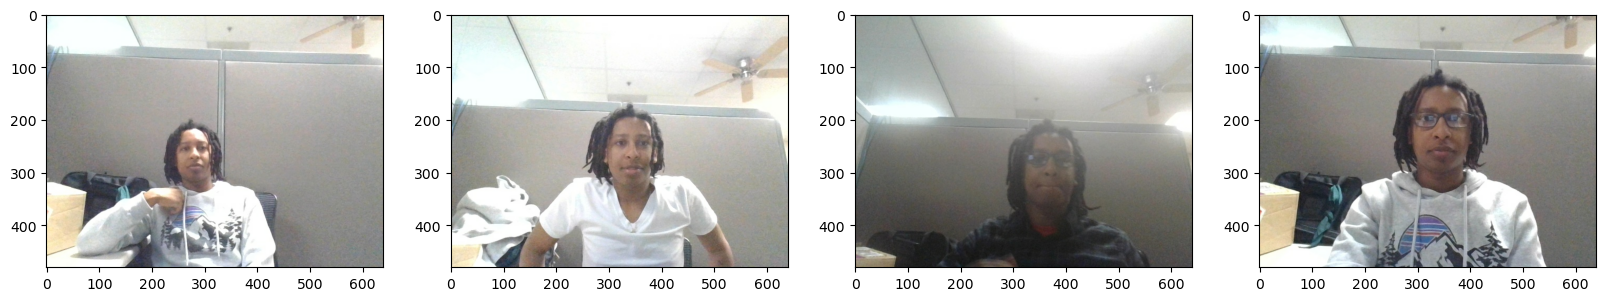

In [20]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## Parition Unaugmented Data
This is mannually splitting data into train, test and validation

#### MOVE the labels

In [21]:
90*0.7 # 63 to train

62.99999999999999

In [22]:
90*0.15 # 14 and 13 to test and val respectively

13.5

In [23]:
63+14+13

90

### Moving the Matching Labels

In [24]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## Applying Image Augmentation on images and Labels using Albumentations

#### Setup

In [25]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
albumentations                1.3.0
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bi


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
testing=cv2.imread(os.path.join('data','val','images','87cb75ec-b92e-11ed-a7e4-c42360996e83.jpg'))

In [27]:
testing.shape #you have to be mindful of this number before you can resize

(480, 640, 3)

In [28]:
import albumentations as alb

In [29]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma (p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

### Load Test Image and Annotation with openCV and JSON

In [30]:
img=cv2.imread(os.path.join('data','train','images','7d6d3e45-b92e-11ed-be1a-c42360996e83.jpg'))

In [31]:
img

array([[[189, 191, 179],
        [184, 186, 174],
        [188, 189, 179],
        ...,
        [139, 155, 168],
        [146, 159, 173],
        [150, 163, 177]],

       [[186, 188, 176],
        [184, 186, 174],
        [188, 189, 179],
        ...,
        [142, 158, 171],
        [144, 157, 171],
        [144, 157, 171]],

       [[186, 188, 176],
        [186, 188, 176],
        [189, 191, 179],
        ...,
        [138, 153, 169],
        [140, 153, 167],
        [139, 152, 166]],

       ...,

       [[255, 255, 252],
        [254, 254, 248],
        [255, 255, 245],
        ...,
        [ 96,  97,  95],
        [ 96,  97,  95],
        [ 95,  96,  94]],

       [[255, 252, 247],
        [255, 255, 248],
        [246, 244, 233],
        ...,
        [ 93,  94,  92],
        [ 98,  99,  97],
        [ 97,  98,  96]],

       [[255, 255, 250],
        [249, 246, 238],
        [237, 233, 222],
        ...,
        [ 94,  95,  93],
        [ 97,  98,  96],
        [ 95,  96,  94]]

In [32]:
with open(os.path.join('data','train','labels','7d6d3e45-b92e-11ed-be1a-c42360996e83.json'),'r') as f:
    label=json.load(f)

In [33]:
label['shapes'][0]['points']

[[249.39393939393938, 115.15151515151518],
 [440.9090909090909, 322.42424242424244]]

In [34]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [35]:
coords

[249.39393939393938, 115.15151515151518, 440.9090909090909, 322.42424242424244]

In [36]:
coords=list(np.divide(coords, [640,480,640,480]))

In [37]:
coords

[0.3896780303030303,
 0.23989898989898997,
 0.6889204545454545,
 0.6717171717171717]

#### Apply Augmentations and View Results

In [38]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [39]:
type(augmented)

dict

In [40]:
augmented

{'image': array([[[102, 100, 100],
         [102,  97,  98],
         [ 99,  94,  95],
         ...,
         [150, 144, 137],
         [150, 144, 137],
         [146, 142, 137]],
 
        [[ 97,  95,  95],
         [ 99,  94,  95],
         [ 99,  94,  95],
         ...,
         [150, 147, 139],
         [150, 147, 139],
         [148, 145, 140]],
 
        [[100,  98,  98],
         [102, 100, 100],
         [106, 101, 102],
         ...,
         [150, 147, 139],
         [151, 148, 140],
         [149, 146, 141]],
 
        ...,
 
        [[149, 161, 173],
         [144, 157, 171],
         [142, 155, 169],
         ...,
         [208, 214, 203],
         [211, 217, 206],
         [214, 221, 208]],
 
        [[145, 157, 169],
         [140, 153, 167],
         [140, 153, 167],
         ...,
         [206, 212, 201],
         [208, 214, 203],
         [211, 218, 205]],
 
        [[146, 155, 168],
         [140, 152, 164],
         [142, 154, 166],
         ...,
         [209, 215,

In [41]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [42]:
augmented['bboxes']

[(0.3602020202020203,
  0.33905723905723906,
  0.7857912457912458,
  0.7996632996632996)]

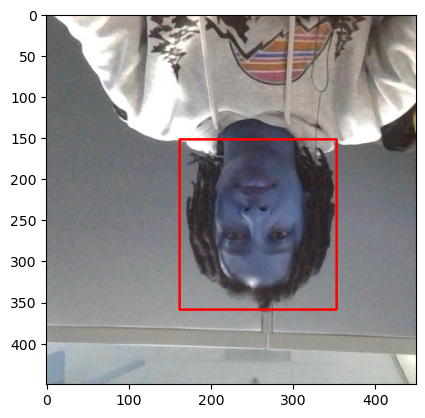

In [43]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

## Build and Run Augmentation Pipeline

#### Run Augmentation Pipeline

In [44]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition,'images')):
        img=cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0,0,0.00001, 0.00001]
        label_path = os.path.join('data', partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open (label_path,'r') as f:
                label = json.load(f)
                
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[640,480,640,480]))
        try:
            for x in range (60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class']= 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)
                

#### Load Augmented Images to Tensorflow Dataset

In [45]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x:tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x:x/255)

In [46]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg',shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x:tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x:x/255)

In [47]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x:tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x:x/255)

In [48]:
train_images.as_numpy_iterator().next()

array([[[0.9867647 , 0.99460787, 0.98284316],
        [0.98970586, 0.997549  , 0.9857843 ],
        [0.9918505 , 0.99969363, 0.9879289 ],
        ...,
        [0.9406863 , 0.9877451 , 0.9406863 ],
        [0.928125  , 0.9893995 , 0.9501838 ],
        [0.9387255 , 0.99264705, 0.9622549 ]],

       [[0.99558824, 1.        , 0.9916667 ],
        [0.9887255 , 0.9965686 , 0.9848039 ],
        [0.99215686, 1.        , 0.9882353 ],
        ...,
        [0.9348652 , 0.9814338 , 0.9431985 ],
        [0.9107843 , 0.9603554 , 0.92512256],
        [0.9117647 , 0.9602941 , 0.92107844]],

       [[0.9728554 , 0.9806985 , 0.9689338 ],
        [0.99264705, 1.        , 0.9887255 ],
        [0.9878064 , 0.9956495 , 0.9838848 ],
        ...,
        [0.9494485 , 0.98474264, 0.9651348 ],
        [0.9400123 , 0.9831495 , 0.95275736],
        [0.9373162 , 0.98290443, 0.9466299 ]],

       ...,

       [[0.50465685, 0.53884804, 0.5768995 ],
        [0.471875  , 0.519424  , 0.57530636],
        [0.49031863, 0

## Prepare Labels

In [49]:
def load_labels(label_path):
    with open (label_path.numpy(),'r',encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']],label['bbox']

In [50]:
##full file path is getting passed 
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
##full file path is getting passed 
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
##full file path is getting passed 
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2395, 0.266 , 0.726 , 0.8345], dtype=float16))

## Combine Label and Image Sample

#### Check partition Length

In [54]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8580, 8580, 2340, 2340, 2400, 2400)

In [55]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(9000) #ideal it should be bigger that your length
train = train.batch(8)
train = train.prefetch(4)

In [56]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3000)
test = test.batch(8)
test = test.prefetch(4)

In [57]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(3000)
val = val.batch(8)
val = val.prefetch(4)

In [58]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [59]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.0814, 0.2612, 0.5635, 0.652 ],
        [0.455 , 0.2401, 0.828 , 0.648 ],
        [0.642 , 0.1505, 0.953 , 0.4407],
        [0.585 , 0.4182, 0.9204, 0.759 ],
        [0.1315, 0.4473, 0.4453, 0.811 ],
        [0.5186, 0.577 , 0.8228, 0.8506],
        [0.3792, 0.2164, 0.7954, 0.661 ],
        [0.3406, 0.3613, 0.6567, 0.7085]], dtype=float16))

#### View Images and Annotations

In [60]:
data_samples= train.as_numpy_iterator() # allows you to loop thru

In [61]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


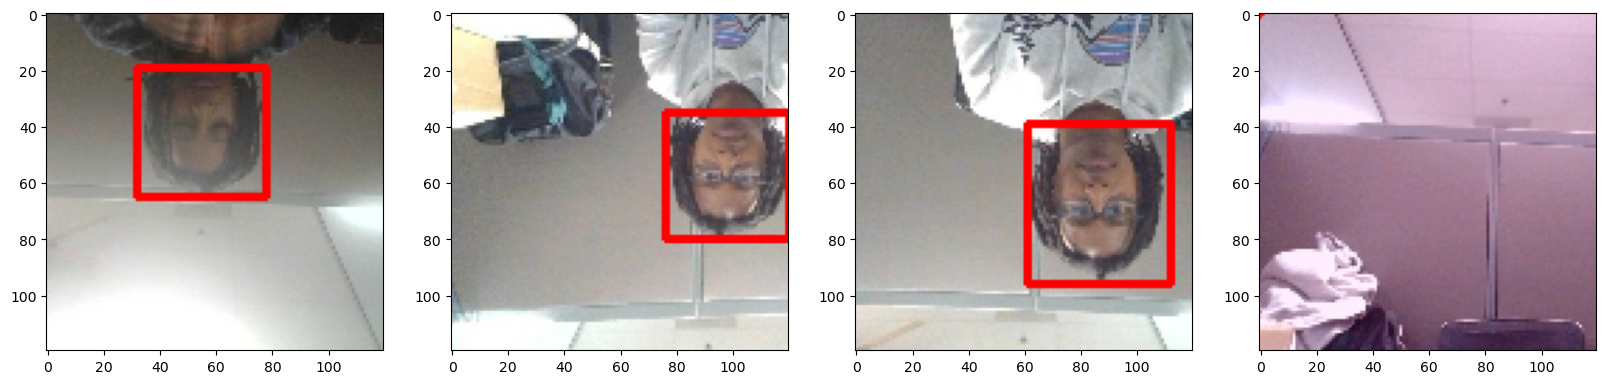

In [62]:
fig, ax=plt.subplots(ncols=4, figsize=(20,20))
for idx in range (4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0),2)
    ax[idx].imshow(sample_image)

## Build Deep Learning using the Functional API

#### Import Layers and Base Network

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### Download VGG16

In [64]:
vgg = VGG16(include_top=False)

In [65]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [66]:
def build_model():
    input_layer=Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    f2=GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2,regress2])
    return facetracker

In [67]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.175  , 0.3516 , 0.5547 , 0.73   ],
        [0.02687, 0.2751 , 0.4458 , 0.663  ],
        [0.2468 , 0.2485 , 0.6655 , 0.636  ],
        [0.4443 , 0.1951 , 0.732  , 0.4617 ],
        [0.4788 , 0.5728 , 0.7573 , 0.9136 ],
        [0.09143, 0.4512 , 0.3555 , 0.7935 ],
        [0.2683 , 0.2898 , 0.6484 , 0.6685 ],
        [0.3909 , 0.1703 , 0.6973 , 0.4768 ]], dtype=float16))

#### Test out Neural Network

In [68]:
facetracker = build_model()

In [69]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [70]:
X, y = train.as_numpy_iterator().next()

In [71]:
X.shape

(8, 120, 120, 3)

In [72]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [73]:
classes, coords

(array([[0.6428019 ],
        [0.58931226],
        [0.59380186],
        [0.575055  ],
        [0.6808945 ],
        [0.5920266 ],
        [0.51591045],
        [0.5358805 ]], dtype=float32),
 array([[0.4661608 , 0.40578407, 0.45761263, 0.29749894],
        [0.4610994 , 0.41574636, 0.6186097 , 0.34766456],
        [0.52821934, 0.43158174, 0.5274256 , 0.32118484],
        [0.5726208 , 0.35740745, 0.54055464, 0.34380084],
        [0.5308964 , 0.4248048 , 0.5965551 , 0.30996537],
        [0.5554173 , 0.3979592 , 0.60591054, 0.29179174],
        [0.5541463 , 0.38956028, 0.56416816, 0.3559012 ],
        [0.6287071 , 0.42294782, 0.5641666 , 0.30581647]], dtype=float32))

## Define Losses and Optimizers

#### Define Optimizer and LR

In [74]:
len(train)

1073

In [75]:
batches_per_epoch = len(train)
lr_decay = (1.0/0.75 -1)/batches_per_epoch

In [76]:
lr_decay

0.0003106554830692761

In [77]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

#### Creating Localization and Loss

In [78]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_prep = yhat[:,3] - yhat[:,1]
    w_prep = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_prep) + tf.square(h_true-h_prep))
    
    return delta_coord + delta_size

In [79]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

#### Test out Loss Metrics

In [80]:
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7286434>

In [81]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6981081>

In [82]:
regressloss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7286434>

## Train Neural Network

#### Create Custom Model Class 

In [83]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
    
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y=batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss =self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)
        
        

In [84]:
model = FaceTracker(facetracker)

In [85]:
model.compile(opt, classloss,regressloss)

#### Train

In [96]:
logdir = 'logs' ##log directory

In [97]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [98]:
hist = model.fit(train.take(500)##<-this could be added to take a smaller sample
                 , epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
500/500 [==============================] - 1408s 3s/step - total_loss: 0.0177 - class_loss: 0.0029 - regress_loss: 0.0163 - val_total_loss: 1.1023 - val_class_loss: 1.3301 - val_regress_loss: 0.4372
Epoch 2/10
500/500 [==============================] - 1480s 3s/step - total_loss: 0.0105 - class_loss: 0.0025 - regress_loss: 0.0093 - val_total_loss: 0.0151 - val_class_loss: 4.7051e-04 - val_regress_loss: 0.0148
Epoch 3/10
500/500 [==============================] - 1526s 3s/step - total_loss: 0.0069 - class_loss: 1.1175e-04 - regress_loss: 0.0068 - val_total_loss: 0.0187 - val_class_loss: 0.0011 - val_regress_loss: 0.0182
Epoch 4/10
500/500 [==============================] - 1589s 3s/step - total_loss: 0.0070 - class_loss: 8.4252e-05 - regress_loss: 0.0069 - val_total_loss: 1.2917 - val_class_loss: 1.2193 - val_regress_loss: 0.6821
Epoch 5/10
500/500 [==============================] - 1741s 3s/step - total_loss: 0.0076 - class_loss: 0.0020 - regress_loss: 0.0066 - val_total_los

In [99]:
hist.history

{'total_loss': [0.009898735210299492,
  0.010433650575578213,
  0.004135073162615299,
  0.004954092670232058,
  0.004799618851393461,
  0.006125214509665966,
  0.008070820942521095,
  0.008810925297439098,
  0.0037664754781872034,
  0.006514203734695911],
 'class_loss': [7.500417268602178e-05,
  1.0915240636677481e-05,
  0.00014836530317552388,
  3.728388765011914e-05,
  1.126544339058455e-05,
  0.0006067626527510583,
  9.6785333880689e-06,
  0.00015540927415713668,
  7.477185863535851e-05,
  0.00012852289364673197],
 'regress_loss': [0.009861232712864876,
  0.010428193025290966,
  0.0040608905255794525,
  0.004935450851917267,
  0.004793986212462187,
  0.00582183338701725,
  0.008065981790423393,
  0.008733220398426056,
  0.003729089628905058,
  0.006449942477047443],
 'val_total_loss': [1.102266788482666,
  0.015061771497130394,
  0.018731065094470978,
  1.2917249202728271,
  3.0490407943725586,
  3.262364387512207,
  2.388094902038574,
  1.1267426013946533,
  1.1244165897369385,
  1

#### Plot performance

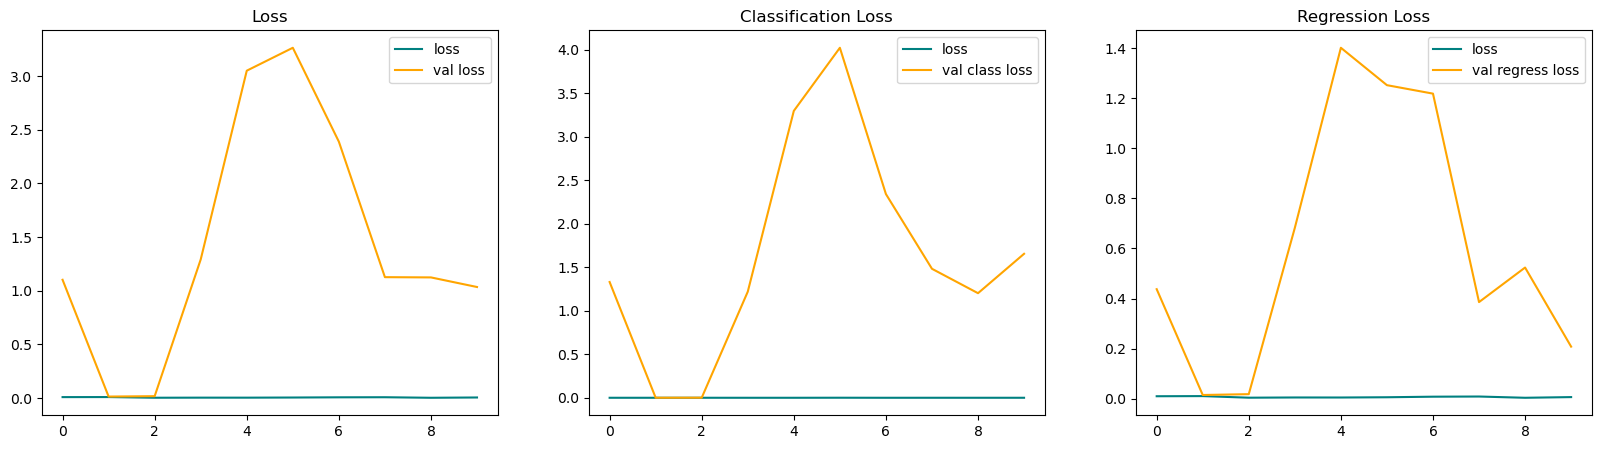

In [100]:
fig, ax =plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange' ,label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='loss')
ax[1].plot(hist.history['val_class_loss'], color='orange' ,label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange' ,label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

#### Make Predictions on Test Set

In [101]:
test_data = test.as_numpy_iterator()

In [102]:
test_sample = test_data.next()

In [103]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


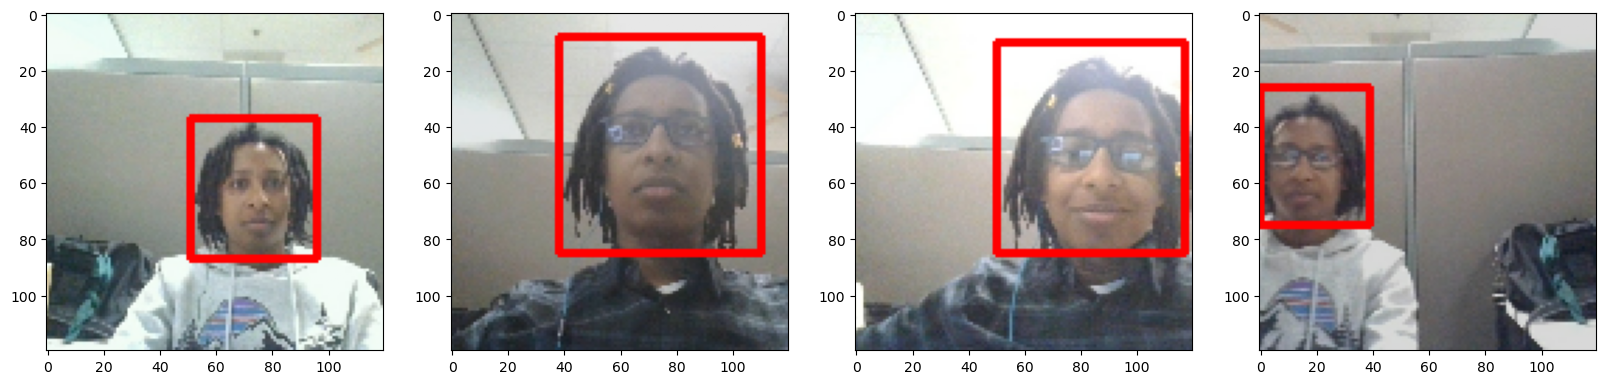

In [104]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] >0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0),2)
    ax[idx].imshow(sample_image)

#### IMPORTANT SAVE THE MODEL

In [1]:
from tensorflow.keras.models import load_model

In [2]:
facetracker.save('facetracker.h5')

NameError: name 'facetracker' is not defined

## Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
                      

1/1 [==============================] - 0s 427ms/step
